In [815]:
# Importación de librerías 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [816]:
# Cargar archivos en los dataframes
costs = pd.read_csv('../datasets/costs_us.csv')
orders = pd.read_csv('../datasets/orders_log_us.csv')
visits = pd.read_csv('../datasets/visits_log_us.csv')

In [ ]:
# Exploración preliminar de los datos
orders.info()
visits.info()
costs.info()

### Plan de acción (exploración preliminar y preparación de los datos)

Para el dataframe "Orders":
- Renombrar la columna "Buy Ts" a "buy_ts"
- Cambiar el tipo de dato de "buy_ts" a datetime
- Renombrar la columna "Revenue" a "revenue"
- Renombrar la columnna "Uid" a "uid"

Para el dataframe "visits":
- Renombrar la columna "Start Ts" a "start_ts"
- Cambiar el tipo de dato de "start_ts" a datetime
- Renombrar la columna "End Ts" a "end_ts"
- Cambiar el tipo de dato de "end_ts" a datetime
- Renombrar la columna "Source Id" a "source_id"
- Renombrar la columna "Device" a "device"
- Renombrar la columna "Uid" a "uid"

Para el dataframe "Costs"
- Cambiar el tipo de dato de "dt" a datetime

In [818]:
# Preparar dataframe 'costs'
costs['dt'] = pd.to_datetime(costs['dt'])
costs['costs'] = pd.to_numeric(costs['costs'], errors = 'coerce')
costs['date'] = costs['dt'].dt.normalize()

# Preparar data frame 'orders'
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['revenue'] =pd.to_numeric(orders['revenue'], errors = 'coerce')
orders['order_date'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

# Preparar dataframe 'visits'
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['device'] = visits['device'].astype('category')
visits['source_id'] = visits['source_id'].astype('category')
visits['duration_mins'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60 

visits['visit_year'] = visits['start_ts'].dt.year
visits['visit_ym'] = visits['start_ts'].dt.to_period('M')
visits['visit_week'] = visits['start_ts'].dt.isocalendar().week
visits['visit_date'] = visits['start_ts'].dt.date

In [ ]:
# Visitas - ¿Cuántas personas lo usan cada día, semana y mes?

# Métricas básicas de uso
mau = visits.groupby('visit_ym')['uid'].nunique().rename('mau').reset_index()
mau['visit_month_str'] = mau['visit_ym'].astype(str)
dau = visits.groupby('visit_date')['uid'].nunique().rename('dau').reset_index()
wau = visits.groupby('visit_week')['uid'].nunique().rename('wau').reset_index()

# Graficar DAU
plt.figure()
plt.plot(dau['visit_date'], dau['dau'])
plt.title('Usuarios activos por día (DAU)')
plt.ylabel('Usuarios únicos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Graficar WAU
plt.figure()
plt.plot(wau['visit_week'], wau['wau'])
plt.title('Usuarios activos por semana (WAU)')
plt.ylabel('Usuarios únicos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Graficar WAU
plt.figure()
plt.plot(mau['visit_month_str'], mau['mau'])
plt.title('Usuarios activos por mes (MAU)')
plt.ylabel('Usuarios únicos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Conclusiones de métricas:

* **Crecimiento por temporada navideña:**
  A partir de septiembre 2017 se aprecia un fuerte aumento de usuarios (DAU/WAU/MAU), con un pico máximo en noviembre, coincidiendo posiblemente con la temporada de ventas navideñas.

* **DAU:**
  En torno a finales de diciembre de 2017 hay un salto muy pronunciado en el DAU (más de 3 000 usuarios en un día), probablemente ligado a una campaña especial navideña. Tras el pico, la actividad cae gradualmente desde enero 2018 hasta abril, estabilizándose algo en mayo.

* **WAU:**
  Se muestran semanas con caídas muy marcadas (por ejemplo, semanas 27–30), lo cual puede deberse a una normalización en las ventas o una baja debido a la suspensión en gastos publicitarios u otra causa aún no identificada.

* **MAU:**
  Se percibe más claramente cómo a partir del mes de septiembre se incrementa la cantidad de usuarios reforzando las métricas DAU/WAU con una perspectiva mensual.

In [ ]:
# Visitas - ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).

# Agrupar las sesiones por día 
sessions_per_day = visits.groupby('visit_date').size().reset_index(name = 'session_count')

# Graficar el dataframe
plt.figure()
plt.plot(sessions_per_day['visit_date'], sessions_per_day['session_count'])
plt.title('Sesiones por día')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Visitas - ¿Cuál es la duración de cada sesión?

p95 = visits['duration_mins'].quantile(0.95)
bins = int(p95)
med = visits['duration_mins'].median()

plt.figure()
plt.hist(visits['duration_mins'], bins=bins, range =(0,p95))
plt.axvline(med, linestyle='--', label=f'Mediana = {med:.1f} min')
plt.title('Distribución de duración de sesiones (minutos)')
plt.xlabel('Duración (min)')
plt.xlim(0, p95)
plt.ylim(0, None)
plt.grid(axis='y', linestyle = '--', linewidth = 0.5, alpha = 0.7)
plt.legend()
plt.ylabel('Número de sesiones')
plt.tight_layout()
plt.show()

In [ ]:
# Visitas - ¿Con qué frecuencia los usuarios regresan?
visits = visits.sort_values(['uid','start_ts'])

# Obtener la fecha previa de ingreso para cada usuario
visits['prev_start'] = visits.groupby('uid')['start_ts'].shift(1)

# Calcular la diferencia en días (Un día tiene 86400 segundos)
visits['days_since_prev'] = (visits['start_ts'] - visits['prev_start']).dt.total_seconds() / 86400

# Eliminar las sesiones que no tienen visita previa
intervals = visits['days_since_prev'].dropna()

#print(intervals.describe())

p95 = intervals.quantile(0.95)

plt.figure()
plt.hist(intervals, bins=30, range=(0, p95))
plt.axvline(intervals.median(), linestyle='--', label=f'Mediana = {intervals.median():.1f} días')
plt.title('Distribución de días entre sesiones')
plt.xlabel('Días desde la sesión previa')
plt.ylabel('Número de sesiones')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Nota: 

- Sesiones múltiples el mismo día.
    - El mínimo de 0 días y el cuartil 1 (≈0.68 días) indican que un 25 % de los retornos ocurre en menos de 16 horas, es decir, muchos usuarios tienen varias sesiones en el mismo día.

- Mediana de 4.9 días
    - La “línea de corte” muestra que la mitad de las veces los usuarios regresan en menos de cinco días, lo cual refleja un nivel razonable de re-engagement semanal.

- Media inflada por outliers (28 días)
    - El promedio es mucho mayor que la mediana debido a la cola larga: hay usuarios que tardan meses en volver.

- Variabilidad alta
    - El cuartil 3 está en 31.9 días, por lo que el 75 % de los retornos suceden en el primer mes.

In [ ]:
# Ventas - ¿Cuándo empieza la gente a comprar?
 
# Obtener la fecha de la primer visita de cada usuario
first_visit_date = visits.groupby('uid')['start_ts'].min()

# Obtener la fecha de la primer compra de cada usuario
first_order_date = orders.groupby('uid')['buy_ts'].min()

# Renombrar los objetos series para poder unirlos
first_visit_date.name = 'first_visit_date'
first_order_date.name = 'first_order_date'

# Unir los dataframes 'visits' y 'first_visits'
converts = pd.concat([first_visit_date, first_order_date], axis=1)

# Obtener la diferencia de las fechas
converts['days_to_convert'] = (converts['first_order_date'] - converts['first_visit_date']).dt.total_seconds() / 86400

bins = [-1, 0, 1, 7, 30, float('inf')]
labels = ['0d', '1d','2-7d','8-30d','30+d']

# Eliminar las visitas que no se convirtieron en compra
converts = converts.dropna(subset=['days_to_convert'])

converts['conv_bucket'] = pd.cut(converts['days_to_convert'], bins = bins, labels = labels)

bucket_counts = (converts.groupby('conv_bucket').size().reindex(['0d', '1d','2-7d','8-30d','30+d'], fill_value=0).rename('user_count'))

overall = converts['conv_bucket'].value_counts(normalize=True).sort_index() * 100

print(overall*100)

# Graficar resultados 
overall.plot(kind='bar')
plt.title('% conversión por segmento de días')
plt.xlabel('Segmentos de días')
plt.ylabel('% de usuarios')
plt.tight_layout()
plt.show()

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\51950883.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = (converts.groupby('conv_bucket').size().reindex(['0d', '1d','2-7d','8-30d','30+d'], fill_value=0).rename('user_count'))


### Interpretación de la gráfica:

- Conversión (1d - 65%)
    - La gran mayoría (>60%) de los usuarios se convierten en compradores en el día siguiente a su primera visita. Inidca que la decisión de compra tarda típicamente unas horas y se materializa al día siguiente. Aquí la recomendación será planificar campañas de recordatorio entre las 12 y 24 horas posteriores.

- Conversión inmediata muy baja (0d - 7%)
    - Solo un pequeño grupo de usuarios se convierte en la misma sesión. La urgencia de compra en el primer contacto es muy reducida. La recomendación para este segmento será el envío de correo electrónico de bienvenida con un descuento válido exclusivamente al día siguiente del registro.

- Conversión (2-7d - 7.8%) y (8-30d - 6.3%)
    - Denota que los esfuerzos para los compradores no están teniendo el rendimiento deseado. La sugerencia para estos grupos es el envío de correos para reactivar el interés de compra de los usuarios. 

- Conversión (30+d - 13.6%)
    - Se muestra que hay un segmento de usuarios que necesitan mucho más tiempo o múltiples recordatorios antes de comprar. La sugerencia para este segmento son recordatorios ligeros que sostengan vivo el carrito de compra animando al cliente a finalizar la compra con mensajes tipo "Ya casi es tuyo!"

In [ ]:
# Ventas - ¿Cuántos pedidos hacen durante un período de tiempo dado?

# Obtener la primer fecha de visita
first_visits = (visits
      .sort_values(['uid', 'start_ts'])
      .drop_duplicates('uid', keep='first')[['uid', 'start_ts']]
      .assign(first_visit_month=lambda df: df['start_ts'].dt.to_period('M'))
      .loc[:, ['uid', 'first_visit_month']])

# Obtener el mes de cada pedido
orders_cohort = (orders
                 .assign(revenue = lambda df: pd.to_numeric(df['revenue'], errors='coerce'))
                 .assign(order_month = lambda df: df['buy_ts'].dt.to_period('M')))

# Unir pedidos con su cohorte de usuario
orders_cohort = orders_cohort.merge(first_visits, on='uid', how='left')

# Calcular el mes relativo de cada pedido
orders_cohort['period_number'] = (orders_cohort['order_month'] - orders_cohort['first_visit_month'])

# Extraer el numero de meses
orders_cohort['period_number'] = orders_cohort['period_number'].apply(lambda x: x.n)

# Convertir a entero el numero de meses
orders_cohort['period_number'] = orders_cohort['period_number'].astype(int)

# Contar los pedidos por cohorte y mes_relativo
cohort_counts = (orders_cohort.groupby(['first_visit_month', 'period_number']).size().reset_index(name='order_count'))

# 5. Pivotear para obtener una tabla de cohortes
cohort_pivot = cohort_counts.pivot(index='first_visit_month', columns='period_number', values='order_count').fillna(0).astype(int)

# Extraer pedidos por usuario:
users_per_cohort = first_visits.groupby('first_visit_month').size()
cohort_rate = cohort_pivot.div(users_per_cohort, axis=0)

# Mostrar mapa de calor
plt.figure(figsize=(10,6))
plt.imshow(cohort_rate, aspect='auto', cmap='Blues')
plt.colorbar(label='Pedidos por usuario')
plt.xticks(ticks=np.arange(len(cohort_rate.columns)), labels=cohort_rate.columns)
plt.yticks(ticks=np.arange(len(cohort_rate.index)), labels=cohort_rate.index.astype(str))
plt.xlabel('Meses desde la primera visita')
plt.ylabel('Cohorte (mes de adquisición)')
plt.title('Pedidos por usuario en cohortes mensuales')
plt.tight_layout()
plt.show()

### Interpretación de la gráfica:

-  La mayoría de los pedidos ocurre en el mes de adquisición (mes 0)
    - Todas las cohortes muestran el valor más oscuro en la columna 0, con un promedio de entre 15 y 18 pedidos por usuario en ese mismo mes.
- Drástica caída en el mes 1 y siguientes.
    - En el mes 1, el promedio baja a 0.03 pedidos / usuario; bajándo incuso hasta quedar en cero a partir del mes 4.
- Pico estacional en cohortes de otoño 2017
    - Las cohortes de sep 2017 - nov 2017 tienen los valores de mes 0 más altos, reflejando buena respuesta en temporada navideña
- Baja recurrencia a largo plazo
    - A partir del tercer mes, el número de pedidos por usuario es prácticamente nulo, lo que sugiere que pocos clientes vuelven a comprar tras los primeros 60 - 90 días.    

In [ ]:
# Ventas -¿Cuál es el tamaño promedio de compra?

# Obtener la cohorte del costo promedio
cohort_avg_value = (orders_cohort.groupby(['first_visit_month','period_number'])['revenue'].mean().reset_index(name='avg_order_value') )

# Pivotar la tabla
cohort_value_pivot = cohort_avg_value.pivot(index='first_visit_month', columns='period_number', values='avg_order_value').fillna(0) 

# Mostrar mapa de calor
plt.figure(figsize=(10,6))
plt.imshow(cohort_value_pivot, aspect='auto', interpolation='none')
plt.colorbar(label='Valor promedio de pedido')
plt.xticks(ticks=np.arange(len(cohort_value_pivot.columns)), labels=cohort_value_pivot.columns)
plt.yticks(ticks=np.arange(len(cohort_value_pivot.index)), labels=cohort_value_pivot.index.astype(str))
plt.xlabel('Meses desde la primera visita')
plt.ylabel('Mes de adquisición)')
plt.title('Tamaño promedio de compra por cohorte y mes relativo')
plt.tight_layout()
plt.show()

In [ ]:
# Ventas - ¿Cuánto dinero traen? (LTV)

# Obtener la cohorte del costo sumarizado
cohort_revenue = (orders_cohort.groupby(['first_visit_month','period_number'])['revenue'].sum().reset_index(name='total_revenue'))

# Pivotar la tabla
revenue_pivot = cohort_revenue.pivot(index='first_visit_month', columns='period_number', values='total_revenue').fillna(0)

# Calcular el LTV acumulado
ltv_cumulative = revenue_pivot.cumsum(axis=1)

# Obtener LTV medio por usuaruio de cada cohorte
ltv_per_user = ltv_cumulative.div(users_per_cohort, axis=0)


users_per_cohort = visits.groupby(visits['start_ts'].dt.to_period('M')).uid.nunique()
ltv_per_user = ltv_cumulative.div(users_per_cohort, axis=0)

plt.figure(figsize=(10,6))
plt.imshow(ltv_per_user, aspect='auto', interpolation='none')
plt.colorbar(label='LTV medio por usuario (USD)')
plt.xticks(ticks=np.arange(len(ltv_per_user.columns)), labels=ltv_per_user.columns)
plt.yticks(ticks=np.arange(len(ltv_per_user.index)), labels=ltv_per_user.index.astype(str))
plt.xlabel('Meses desde primera visita')
plt.ylabel('Cohorte (mes de adquisición)')
plt.title('LTV medio por usuario por cohorte y mes relativo')
plt.tight_layout()
plt.show()

### Interpretación de la gráfica:

-  Crecimiento acumulado: 
    - Todas las cohortes incrementan su LTV mes a mes, pero la pendienty el nivel absoluto varían mucho seún cuando se adquirieron.
- Cohortes destacables en Jun - Sep 2017:
    - La cohorte de Jun - 2017 alcanza un LTV medio de > 3 USD por usuario a los 11 meses, la más alta de todas
    - La cohorte de Sep - 2017 también muestran picos fuertes, con  LTV medio que supera los 1.5 a 2 USD en los primeros 6 - 8 meses.
- Cohortes de inicios de 2018 con LTV bajo y plano:
    - Los usuarios adquiridos en Ene - May 2017 empiezan con LTV de 0.4 USD en el mes 0 y apenas llegan a 0.6 USD aún tras varios meses, lo que indica menor valor del tiempo de vida.

In [ ]:
# Marketing - ¿Cuánto dinero se gastó? (Total / fuente de addquisición / a lo largo del tiempo)

# Obtener el coste total por dia
total_daily = costs.groupby('date')['costs'].sum().reset_index().rename(columns={'costs':'total_cost'})

# Obtener el coste por día y fuente
source_daily = costs.groupby(['date', 'source_id'])['costs'].sum().reset_index()

# Pivotear para obtener fechas x fuentes
cost_pivot = source_daily.pivot(index='date', columns='source_id', values='costs').fillna(0)

# Obtener el costo acumulado
cost_cum = cost_pivot.cumsum()

# Visualización - Costo total a lo largo del tiempo
plt.figure()
plt.plot(total_daily['date'], total_daily['total_cost'])
plt.title('Coste total de marketing por día')
plt.ylabel('Coste (USD)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualización - Costo diario por fuente
plt.figure()
for src in cost_pivot.columns:
    plt.plot(cost_pivot.index, cost_pivot[src], label=f'Source {src}')
plt.title('Coste diario por fuente de adquisición')
plt.ylabel('Coste (USD)')
plt.legend(title='Fuente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualización - Costo acumulado por fuente
plt.figure()
for src in cost_cum.columns:
    plt.plot(cost_cum.index, cost_cum[src], label=f'Source {src}')
plt.title('Coste acumulado de marketing por fuente')
plt.xlabel('Fecha')
plt.ylabel('Coste acumulado (USD)')
plt.legend(title='Fuente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Interpretación de las gráficas:

- Costo total a lo largo del tiempo
    - Se observa una subida progresiva hasta finales de 2017, adicional a un pico navideño, existe una estabilización y descenso en 2018 junto con una reactivación al cierre de período. Se observa un claro patrón estacional con máximos de inversión en el 4 trimestre para capturar la demanda navideña y ajustes posteriores en los meses de menor actividad.
- Costo diario por fuente    
    - La fuente 3 domina la inversión, las 4 y 5 con aportes medios - altos, la 1 y 2 aportan de forma constante pero menor; la 9 y 10 tienen gasto casi testimonial y todas suben su gasto en los meses nov - dic.
- Costo acumulado por fuente
    - La fuente 3 lidera con gran holgura, las 4 y 5 en segundo escalón, la 1 y 2 aportan de forma moderada y la 9 y 10 con inversión muy baja. Se observa adicionalmente una estrategia concentrada e la fuente 3, seguida por las 4 y 5, mientras que las fuentes 9 y 10 podrían redistribuir su escaso presupuesto hacia canales de mayor rendimiento.

In [828]:
# Marketing - ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

# Identificar la adquisicion de cada usuario
first_visits = visits.sort_values(['uid', 'start_ts']).drop_duplicates(subset='uid', keep='first')[['uid','source_id']].rename(columns={'source_id':'acquisition_source'})

# Obtener los usuarios únicos por fuente
users_per_source = first_visits.groupby('acquisition_source').size().reset_index(name='new_users')

# Sumar todo el gasto de marketing por fuente
cost_per_source = costs.groupby('source_id')['costs'].sum().reset_index(name='total_cost').rename(columns={'source_id':'acquisition_source'})

# Unir ambas tablas y calculo del CAC
cac = users_per_source.merge(cost_per_source, on ='acquisition_source', how='left').assign(cac=lambda df: df['total_cost'] / df['new_users']).sort_values('cac').reset_index(drop=True)

print(cac)

   acquisition_source  new_users  total_cost       cac
0                  10       6903     5822.49  0.843472
1                   4      72346    61073.60  0.844188
2                   9       6448     5517.49  0.855690
3                   5      49237    51757.10  1.051183
4                   3      66116   141321.63  2.137480
5                   1       9469    20833.27  2.200155
6                   2      17616    42806.04  2.429952
7                   6          2         NaN       NaN
8                   7         32         NaN       NaN


C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\3366738158.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  users_per_source = first_visits.groupby('acquisition_source').size().reset_index(name='new_users')


### Interpretación de resultados:
- Las fuentes más eficientes son las 4, 9 y 10, por debajo de 1; son altamente recomendables para escalar inversión.
- La fuente 5 supera ligeramente la unidad pero tiene margen para optimizarse.
- Las fuentes 1, 2 y 3 superan los 2 dólares y salen más caras, conviene revisar el rendimiento y ajustar el presupuesto o creatividades.

In [ ]:
# Marketing - ¿Cuán rentables eran las inversiones? (ROMI)

# Obtener el total por usuario
user_revenue = orders.groupby('uid')['revenue'].sum().reset_index(name='total_revenue')

# Asignar a cada fuente el ingreso agregado.
revenue_by_source = first_visits.merge(user_revenue, on = 'uid', how = 'left').groupby('acquisition_source')['total_revenue'].sum().reset_index()

cost_per_source = costs.groupby('source_id')['costs'].sum().reset_index(name='total_cost').rename(columns={'source_id':'acquisition_source'})

romi = (revenue_by_source.merge(cost_per_source, on = 'acquisition_source', how = 'left')
      .assign(
         romi = lambda df: df['total_revenue'] / df['total_cost'],
         roi  = lambda df: (df['total_revenue'] - df['total_cost']) / df['total_cost'])
      .sort_values('romi', ascending=False)
      .reset_index(drop=True))

print(romi)

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\911309469.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_source = first_visits.merge(user_revenue, on = 'uid', how = 'left').groupby('acquisition_source')['total_revenue'].sum().reset_index()


### Interpretación de resultados:

- Canales rentables (ROMI)
    - 1. Gana $0.49 por cada USD invertido
    - 2. Gana $0.09 por cada USD invertido
    - 9. Gana $0.04 por cada USD invertido
    - 5. Gana $0.01 por cada USD invertido
    
    Estos canales generan más ingresos de los que cuestan; conviene mantener o incluso aumentar presupuesto en estos canales.

- Canales NO rentables (ROMI < 1)
    - 4. Pierde $0.07 por cada USD invertido
    - 10. Pierde $0.24 por cada USD invertido
    - 3. Pierde $0.61 por cada USD invertido
    
    Estos canales deben revisarse y optimizarse, ya que actualmente generan pérdida.

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\2753626858.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sessions_device = visits.groupby(['visit_date','device']).size().unstack(fill_value=0)


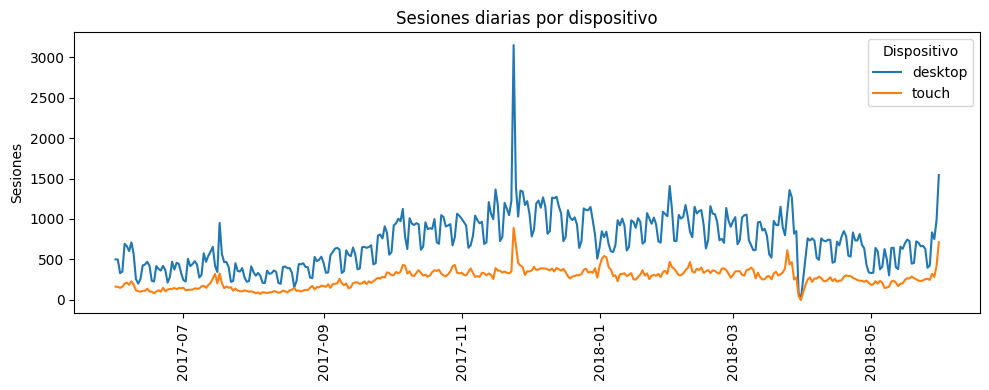

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\2753626858.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dau_device = visits.groupby(['visit_date','device'])['uid'].nunique().unstack(fill_value=0)


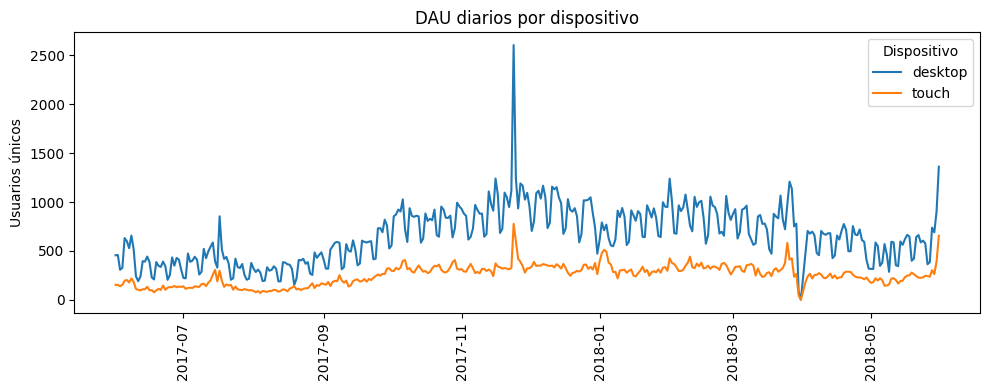

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\2753626858.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_per_day_source = orders.groupby(['order_date','acquisition_source']).size().unstack(fill_value=0)


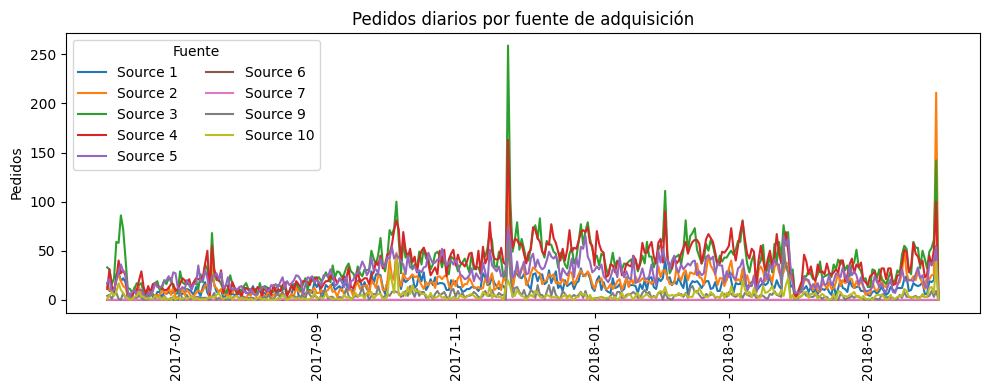

C:\Users\Disponible\AppData\Local\Temp\ipykernel_46004\2753626858.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rev_per_day_source = orders.groupby(['order_date','acquisition_source'])['revenue'].sum().unstack(fill_value=0)


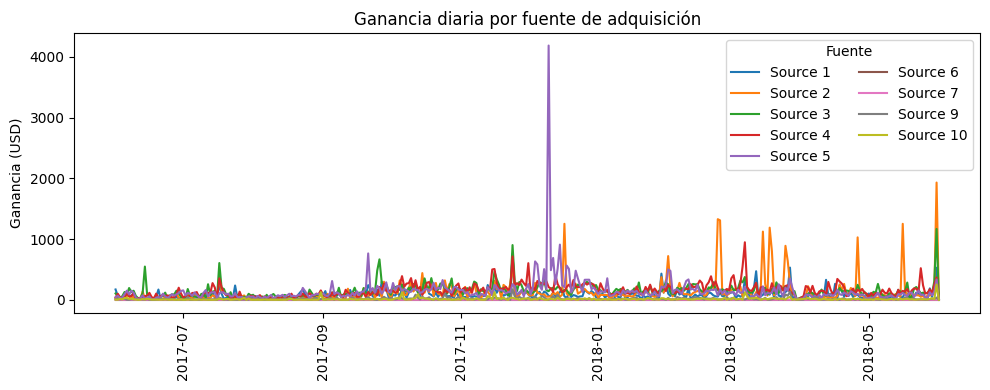

In [830]:
# Marketing - Sesiones diarias por dispositivo
sessions_device = visits.groupby(['visit_date','device']).size().unstack(fill_value=0)

plt.figure(figsize=(10,4))
for dev in sessions_device.columns:
    plt.plot(sessions_device.index, sessions_device[dev], label=dev)
plt.title('Sesiones diarias por dispositivo')
plt.ylabel('Sesiones')
plt.legend(title='Dispositivo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# DAU diarios por dispositivo
dau_device = visits.groupby(['visit_date','device'])['uid'].nunique().unstack(fill_value=0)

plt.figure(figsize=(10,4))
for dev in dau_device.columns:
    plt.plot(dau_device.index, dau_device[dev], label=dev)
plt.title('DAU diarios por dispositivo')
plt.ylabel('Usuarios únicos')
plt.legend(title='Dispositivo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Pedidos diarios por fuente
first_visits = visits.sort_values(['uid','visit_date']).drop_duplicates('uid',keep='first')[['uid', 'source_id']].rename(columns={'source_id':'acquisition_source'})

orders = orders.merge(first_visits, on='uid', how='left')

orders_per_day_source = orders.groupby(['order_date','acquisition_source']).size().unstack(fill_value=0)

plt.figure(figsize=(10,4))
for src in orders_per_day_source.columns:
    plt.plot(orders_per_day_source.index, orders_per_day_source[src], label=f'Source {src}')
plt.title('Pedidos diarios por fuente de adquisición')
plt.ylabel('Pedidos')
plt.legend(title='Fuente', ncol=2)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Ganancia diaria por fuente
rev_per_day_source = orders.groupby(['order_date','acquisition_source'])['revenue'].sum().unstack(fill_value=0)

plt.figure(figsize=(10,4))
for src in rev_per_day_source.columns:
    plt.plot(rev_per_day_source.index, rev_per_day_source[src], label=f'Source {src}')
plt.title('Ganancia diaria por fuente de adquisición')
plt.ylabel('Ganancia (USD)')
plt.legend(title='Fuente', ncol=2)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Interpretación de las gráficas.

- Sesiones y DAU por dispositivo.
    - Las sesiones por escritorio dominan; hay de 2 a 3 veces más conexiones que otros dispositivos.
    - Patrón de ventas estacional; ambos picos coinciden con las fechas de mayores ventas.
- Pedidos diarios por fuente.
    - Las fuentes 3 y 4 son los que registran los picos más altos de pedidos diarios.
    - La fuente 2 crece en 2018, llegando a igualar o superar a las demás fuentes.
    - Los canales 6, 7, 10 casi no aportan, por lo que debería considerarse su continuidad.
- Ganancia diaria por fuente.
    - La fuente 5 descaca con una gran racha de ingresos ($4,000. USD), pero luego se modera.
    - Las fuentes 2 y 3 generan flujos consistentes después de su lanzamiento.
    - El resto de canales aportan ganancias mínimas.

## Conclusiones generales del proyecto

- ¿Qué fuentes / plataformas recomendarías?
    - Las mejores fuentes (en orden de recomendación) son las 1, 2, 9 y 5, ya que su ROMI es mayor a 1 y recuperan más de cada dolar invertido.

- Métricas clave
    - Las métricas utilizadas son ROMI, CAC y LTV.
    - Fuente 1 (ROMI = $1.49, CAC = $2.20)
    - Fuente 2 (ROMI = $1.10, CAC = $2.43)
    - Fuente 9 (ROMI = $1.04, CAC = $0.86)
    - Fuente 5 (ROMI = $1.02, CAC = $1.05)

### Conclusiones finales:
- Maximizar el presupuesto a la fuente 1 y explotar su alto ROMI.
- Escalar fuente 9 por su CAC bajo y retorno positivo.
- Mantener o aumentar gradualemnte inversión en fuente 2 y 5.
- Reasignar o revisar el presupuesto de las fuentes con ROMI < 1 (3, 4, 10)
- Revisar periódicamente el LTV y retención de usuarios de cada fuente para ajustar campañas de venta.

In [831]:
#

#first_visits = (visits
#      .sort_values(['uid', 'start_ts'])
#      .drop_duplicates('uid', keep='first')[['uid', 'start_ts']]
#      .assign(first_visit_month=lambda df: df['start_ts'].dt.to_period('M'))
#      .loc[:, ['uid', 'first_visit_month']])

#orders_cohort = (orders
#      # Aseguramos que buy_ts es datetime
#      .assign(buy_ts = lambda df: pd.to_datetime(df['buy_ts']))
#      # Añadimos columna de “order_month” como periodo mensual
#      .assign(order_month = lambda df: df['buy_ts'].dt.to_period('M')))

#orders_cohort = orders_cohort.merge(first_visits, on='uid', how='left')

#orders_cohort['period_number'] = (orders_cohort['order_month'] - orders_cohort['first_visit_month'])


#orders_cohort['period_number'] = orders_cohort['period_number'].astype(int)

#cohort_counts = (orders_cohort.groupby(['first_visit_month', 'period_number']).size().reset_index(name='order_count'))


#print(orders_cohort)

# Crear una copia del dataframe orders
#orders_cohort = orders

# Integrar la fecha de la primer órden
#orders_cohort = orders_cohort.join(first_order_date, on = 'uid')

# Extraer el mes de la primer compra
#orders_cohort['first_order_month'] = orders_cohort['first_order_date'].dt.to_period('M')

# Convertir la fecha de la primer orden en tipo date (sin horas)
#orders_cohort['first_order_date'] = orders_cohort['first_order_date'].dt.date


#orders_cohort['month'] = orders_cohort[' ']
#converts['first_visit_month'] = converts['first_visit_date'].dt.to_period('M')
#converts['first_order_month'] = converts['first_order_date'].dt.to_period('M')

#print(orders_cohort)
